## Activity 3. The Hugging Face Hub

<img alt="ecosystem" width="500" caption="An overview of the Hugging Face ecosystem of libraries and the Hub." src="images/chapter01_hf-ecosystem.png" id="ecosystem"/>
 



Text classification is one of the most common tasks in NLP; it can be used for a broad range of applications, such as tagging customer feedback into categories or routing support tickets according to their language. 

Another common type of text classification is sentiment analysis, which aims to identify the polarity of a given text. 

**Project**: build a system that can automatically identify emotional states such as "anger" or "joy" that people express about a certain event, product or phenomenon on Twitter. 

We will use a model variant of BERT called DistilBERT - See:[V. Sanh et al., ["DistilBERT, a Distilled Version of BERT: Smaller, Faster, Cheaper and Lighter"](https://arxiv.org/abs/1910.01108), (2019).] 

The main advantage of this model is that it achieves comparable performance to BERT, while being significantly smaller and more efficient. This enables us to train a classifier in a few minutes, and if you want to train a larger BERT model you can simply change the checkpoint of the pretrained model. A _checkpoint_ corresponds to the set of weights that are loaded into a given transformer architecture.

This will also be our first encounter with three of the core libraries from the Hugging Face ecosystem:  

- Datasets
- Tokenizers, and 
- Transformers. 

<img alt="Hugging Face Pipeline" caption="A typical pipeline for training transformer models with the image:images/logo.png[hf,13,13] Datasets, image:images/logo.png[hf,13,13] Tokenizers, and image:images/logo.png[hf,13,13] Transformers libraries" src="images/chapter02_hf-libraries.png" id="hf-libraries"/>

## The Dataset

For this project we will use one of the most popular HF datasets, `emotion`.

It is a dataset from an article that explored how emotions are represented in English Twitter messages.

See: Saravia et al., "CARER: Contextualized Affect Representations for Emotion Recognition," _Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing_ (Oct–Nov 2018): 3687–3697, http://dx.doi.org/10.18653/v1/D18-1404.

Unlike most sentiment analysis datasets that involve just "positive" and "negative" polarities, this dataset contains six basic emotions: 
- anger, 
- disgust, 
- fear, 
- joy, 
- sadness, and 
- surprise. 

Given a tweet, our task will be to train a model that can classify it into one of these emotions.

### A First Look at Hugging Face Datasets

We will use image:images/logo.png[hf,13,13] Datasets to download the data from the [Hugging Face Hub](https://huggingface.co/datasets). We can use the `list_datasets()` function to see what datasets are available on the Hub:

In [ ]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 1753 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa',
'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue',
'ajgt_twitter_ar', 'allegro_reviews']


We see that each dataset is given a name, so let's load the `emotion` dataset with the `load_dataset()` function:

In [ ]:
# hide_output
from datasets import load_dataset

emotions = load_dataset("emotion")

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Using custom data configuration default
Reusing dataset emotion (/Users/lewtun/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

If we look inside our `emotions` object:

In [ ]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

we see it is similar to a Python dictionary, with each key corresponding to a different split. And we can use the usual dictionary syntax to access an individual split:

In [ ]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

which returns an instance of the `Dataset` class. The `Dataset` object is one of the core data structures in image:images/logo.png[hf,13,13] Datasets, and we'll be exploring many of its features throughout the course of this book. For starters, it behaves like an ordinary Python array or list, so we can query its length:

In [ ]:
len(train_ds)

16000

or access a single example by its index:

In [ ]:
train_ds[0]

{'label': 0, 'text': 'i didnt feel humiliated'}

Here we see that a single row is represented as a dictionary, where the keys correspond to the column names:

In [ ]:
train_ds.column_names

['text', 'label']

and the values are the tweet and the emotion. This reflects the fact that image:images/logo.png[hf,13,13] Datasets is based on [_Apache Arrow_](https://arrow.apache.org/), which defines a typed columnar format that is more memory efficient than native Python. We can see what data types are being used under the hood by accessing the `features` attribute of a `Dataset` object:

In [ ]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6,
names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None,
id=None)}


In this case, the data type of the `text` column is `string`, while the `label` column is a special `ClassLabel` object that contains information about the class names and their mapping to integers. We can also access several rows with a slice:

In [ ]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so
damned hopeful just from being around someone who cares and is awake', 'im
grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic
about the fireplace i will know that it is still on the property', 'i am feeling
grouchy'], 'label': [0, 0, 3, 2, 3]}


Note that in this case, the dictionary values are now lists instead of individual elements. We can also get the full column by name:

In [ ]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned
hopeful just from being around someone who cares and is awake', 'im grabbing a
minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the
fireplace i will know that it is still on the property', 'i am feeling grouchy']


### External dataset

Datasets provides several loading scripts to handle local and remote datasets. 

Examples for the most common data formats are shown below

```asciidoc
[[dataset-loading]]
.How to load datasets in various formats
[options="header"]
|======
| Data format | Loading script | Example
| CSV | `csv` | `load_dataset("csv", data_files="my_file.csv")` 
| Text | `text` | `load_dataset("text", data_files="my_file.txt")` 
| JSON | `json` | `load_dataset("json", data_files="my_file.jsonl")`
|======
```

We just need to pass the relevant loading script to the `load_dataset()` function, along with a `data_files` argument that specifies the path or URL to one or more files. For example, the source files for the `emotion` dataset are actually hosted on Dropbox, so an alternative way to load the dataset is to first download one of the splits:

In [ ]:
#hide_output
# The original URL used in the book is no longer available, so we use a different one
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
!wget {dataset_url}

--2023-02-14 19:24:47--  https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt
Resolving huggingface.co (huggingface.co)... 54.235.118.239, 3.231.67.228, 2600:1f18:147f:e850:e203:c458:10cd:fc3c, ...
Connecting to huggingface.co (huggingface.co)|54.235.118.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1658616 (1,6M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   1,58M  1,06MB/s    in 1,5s    

2023-02-14 19:24:49 (1,06 MB/s) - ‘train.txt’ saved [1658616/1658616]



A `!` character in the preceding shell command is a magic command to run this line in a Jupyter notebook. Now, if we peek at the first row of the _train.txt_ file:

In [ ]:
!head -n 1 train.txt

i didnt feel humiliated;sadness


we can see that here are no column headers and each tweet and emotion are separated by a semicolon. Nevertheless, this is quite similar to a CSV file, so we can load the dataset locally by using the `csv` script and pointing the `data_files` argument to the _train.txt_ file:

In [ ]:
#hide_output
emotions_local = load_dataset("csv", data_files="train.txt", sep=";", 
                              names=["text", "label"])

Using custom data configuration default-dd8fa13a78374240


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /Users/lewtun/.cache/huggingface/datasets/csv/default-dd8fa13a78374240/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


/Users/lewtun/miniconda3/envs/book/lib/python3.8/site-packages/datasets/packaged_modules/csv/csv.py:170: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

Here we've also specified the type of delimiter and the names of the columns. An even simpler approach is to just point the `data_files` argument to the URL itself:

In [ ]:
#hide_output
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";", 
                               names=["text", "label"])

Using custom data configuration default-77d91d09868a1841


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /Users/lewtun/.cache/huggingface/datasets/csv/default-77d91d09868a1841/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


/Users/lewtun/miniconda3/envs/book/lib/python3.8/site-packages/datasets/packaged_modules/csv/csv.py:170: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

which will automatically download and cache the dataset for you. As you can see, the `load_dataset()` function is very versatile. We recommend checking out the image:images/logo.png[hf,13,13] Datasets [documentation](https://huggingface.co/docs/datasets/loading.html) to get a complete overview.

### From Datasets to DataFrames

Although Datasets provides a lot of low-level functionality to slice and dice our data, it is often convenient to convert a `Dataset` object to a Pandas `DataFrame` so we can access high-level APIs for data visualization. To enable the conversion, Datasets provides a `set_format()` method that allows us to change the _output format_ of the `Dataset`. Note that this does not change the underlying _data format_ (which is an Arrow table), and you can switch to another format later if needed:

In [ ]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


As you can see, the column headers have been preserved and the first few rows match our previous views of the data. However, the labels are represented as integers, so let's use the `int2str()` method of the `label` feature to create a new column in our `DataFrame` with the corresponding label names:

In [ ]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Before diving into building a classifier, let's take a closer look at the dataset. 

### Looking at the Class Distribution

Whenever you are working on text classification problems, it is a good idea to examine the distribution of examples across the classes. A dataset with a skewed class distribution might require a different treatment in terms of the training loss and evaluation metrics than a balanced one. 

With Pandas and Matplotlib, we can quickly visualize the class distribution as follows:

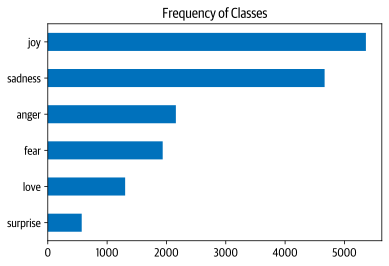

In [ ]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In this case, we can see that the dataset is heavily imbalanced; the `joy` and `sadness` classes appear frequently, whereas `love` and `surprise` are about 5–10 times rarer. There are several ways to deal with imbalanced data, including:

* Randomly oversample the minority class.
* Randomly undersample the majority class.
* Gather more labeled data from the underrepresented classes.

To start we'll work with the raw, unbalanced class frequencies. 

Note: sampling techniques are covered in more depth in [Imbalanced-learn library](https://imbalanced-learn.org/stable/). 
Just make sure that you don't apply sampling methods _before_ creating your train/test splits, to avoid data leakage. 

Now that we've looked at the classes, let's take a look at the tweets themselves.

### How Long Are Our Tweets?

Transformer models have a maximum input sequence length that is referred to as the _maximum context size_. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text. As we'll see in the next section, a token is an atomic piece of text; for now, we'll treat a token as a single word. We can get a rough estimate of tweet lengths per emotion by looking at the distribution of words per tweet:

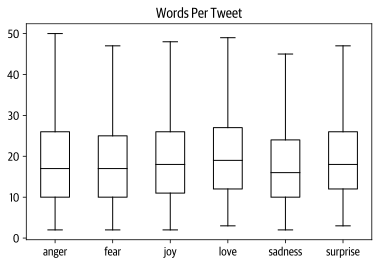

In [ ]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

From the plot we see that for each emotion, most tweets are around 15 words long and the longest tweets are well below DistilBERT's maximum context size. Texts that are longer than a model's context size need to be truncated, which can lead to a loss in performance if the truncated text contains crucial information; in this case, it looks like that won't be an issue. 

The next step will be preprocess the dataset for a format more suitable for transformers. We will do it in the next session.


For now, we will just reset the output format of our dataset since we don't need the `DataFrame` format anymore: 

In [ ]:
emotions.reset_format()